## Identifying Machine Learning topics on Twitter: A Data Science Approach

### Introduction
In this task, I have been asked to demonstrate some analysis of a [Tweepy](http://www.tweepy.org/) dataset containing approximately 15k tweets from Twitter accounts associated with machine learning. The main objective is to identify significant insights which represent popular concepts or topics of conversation within the machine learning crowd. 

The data science approach adopted to explore and analyze the dataset is a **light-weight** version of the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) standard process for data mining shown below:

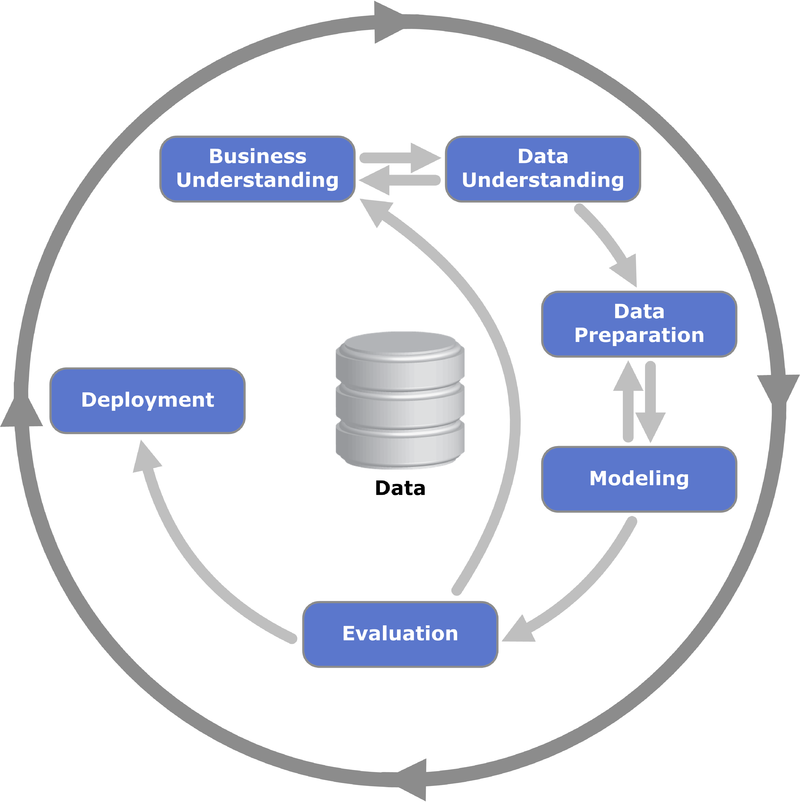

In [1]:
from IPython.display import Image
Image("./CRISP-DM_Process_Diagram.png", width=400, height=300)

In [2]:
import tweepy
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
pd.set_option('display.max_colwidth', -1)

### Data Understanding
As said initially, the main objective is to identify significant insights which represent popular topics of conversation within the machine learning crowd. As this task is purely demonstrational, thus there is no business / case study involved, we will therefore start with the data understanding phase

In [3]:
with open('ml_tweets.bin',mode='rb') as file:
   tweets = pickle.load(file)

#### Size and Type

In [4]:
print("There are %s tweets each with type %s" % (len(tweets), type(tweets[0])))

There are 15197 tweets each with type <class 'tweepy.models.Status'>


#### Available raw attributes

In [5]:
json_tweet = tweets[2]._json
json_tweet.keys()

dict_keys(['retweeted', 'in_reply_to_status_id_str', 'favorited', 'entities', 'in_reply_to_user_id_str', 'in_reply_to_user_id', 'coordinates', 'id_str', 'source', 'place', 'display_text_range', 'favorite_count', 'retweeted_status', 'possibly_sensitive', 'user', 'truncated', 'lang', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'id', 'retweet_count', 'created_at', 'is_quote_status', 'contributors', 'geo', 'full_text'])

#### Snapshot of some interesting attributes

In [6]:
#convert the Tweepy Status tweets to a data frame of JSON objects 
json_tweets = [x._json for x in tweets]
tweetsDF = pd.DataFrame(json_tweets)

In [7]:
#some feature engineering functions to extract interesting attributes
def hashtags(t):
    try:
        return ', '.join([x['text'] for x in t['entities']['hashtags']])
    except KeyError:
        return None
def screen_names(t):
    try:
        return t['user']['screen_name']
    except KeyError:
        return None
def locations(t):
    try:
        return t['user']['location']
    except KeyError:
        return None
def retweet(t):
    try:
        return type(t['retweeted_status']) == dict
    except KeyError:
        return False 
def created_at_ts(t):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(t['created_at'],'%a %b %d %H:%M:%S +0000 %Y'))

In [8]:
#derive the attributes and display a snapshot of the data frame
tweetsDF['hashtags'] = tweetsDF.apply(hashtags, axis=1) #extract the hashtags
tweetsDF['screen_name'] = tweetsDF.apply(screen_names, axis=1) #extract the user screen names
tweetsDF['location'] = tweetsDF.apply(locations, axis=1) #extract the user locations
tweetsDF['retweet'] = tweetsDF.apply(retweet, axis=1) #is the tweet a retweet? 
tweetsDF['created_at_ts'] = tweetsDF.apply(created_at_ts, axis=1) #tweet creation timespamp  
tweetsDF[['full_text', 'hashtags', 'screen_name', 'location', 'retweet', 'created_at_ts']].head(10)

,full_text,hashtags,screen_name,location,retweet,created_at_ts
0,"TensorFlow at Google I/O 2018! \n\nHere's a recap of Tensorflow’s presence at #io18, including 7 Sessions and our AI &amp; Machine Learning Sandbox featuring cool, Machine Learning-powered demos\n\nRead the post here ↓\n\nhttps://t.co/XnpJpyeBzy",io18,TensorFlow,"Mountain View, CA",False,2018-05-25 17:07:33
1,Interested in publishing on TF Hub? Take the survey! \n\nGet started here → https://t.co/wWAkowLFSQ https://t.co/6ig38g5PJV,,TensorFlow,"Mountain View, CA",False,2018-05-24 19:00:01
2,RT @martin_gorner: ⚡️ “Tensorflow eager execution in 12 tweets”\n\nhttps://t.co/WAGCKTr9yg,,TensorFlow,"Mountain View, CA",True,2018-05-24 18:10:17
3,"RT @github: Congratulations, @tensorflow! With projects like this, it's no wonder you reached 100K stars. https://t.co/Exx1F0IEgp https://t…",,TensorFlow,"Mountain View, CA",True,2018-05-23 20:30:00
4,"With @RStudio now supporting TensorFlow and Keras, @random_forests sat down with R Studio Founder J. J. Allaire to talk about his work and the educational resources available for R developers new to deep learning. \n\nWatch their talk here → https://t.co/Ip0SyOT7NJ https://t.co/dDDI2FhXjU",,TensorFlow,"Mountain View, CA",False,2018-05-22 23:36:28
5,Check out this tutorial for Fashion MNIST using tf.keras. @margaretmz defines and trains a model in just a few lines of code. \n\nRead the post here ↓ https://t.co/Y6CK8Tpsl9,,TensorFlow,"Mountain View, CA",False,2018-05-21 20:07:28
6,"New features in TensorFlow.js 0.11: Saving and loading models using browser Local Storage, IndexedDB &amp; file downloads, new ops, new layers and much more. \n\nSee release notes here → https://t.co/iTAegLjaNl\n\nFind a tutorial for model saving/loading here ↓ https://t.co/Dy1VNi8qpj",,TensorFlow,"Mountain View, CA",False,2018-05-18 20:17:01
7,"This week on #AskTensorFlow, we recommend some places to start if you're new to ML and you're ready to dive in. \n\nWe also cover managing categorical inputs, ways to contribute to the TensorFlow project and more.\n\nWatch the full episode here → https://t.co/dsG2g4DJQG https://t.co/moLM6jBb10",AskTensorFlow,TensorFlow,"Mountain View, CA",False,2018-05-15 22:33:01
8,RT @DeepMindAI: Pleased to share DeepMind's I3D action recognition models on the @TensorFlow Hub platform! https://t.co/WRLFdR29B7,,TensorFlow,"Mountain View, CA",True,2018-05-14 20:21:26
9,"Propose a talk for the TensorFlow Community Day at this year’s OSCON (July 17, Portland, OR) \n\nLearn more in @edd's post to the TensorFlow blog ↓ https://t.co/Nfi5ogs1Zl",,TensorFlow,"Mountain View, CA",False,2018-05-14 17:07:34


#### Top 10 hashtags

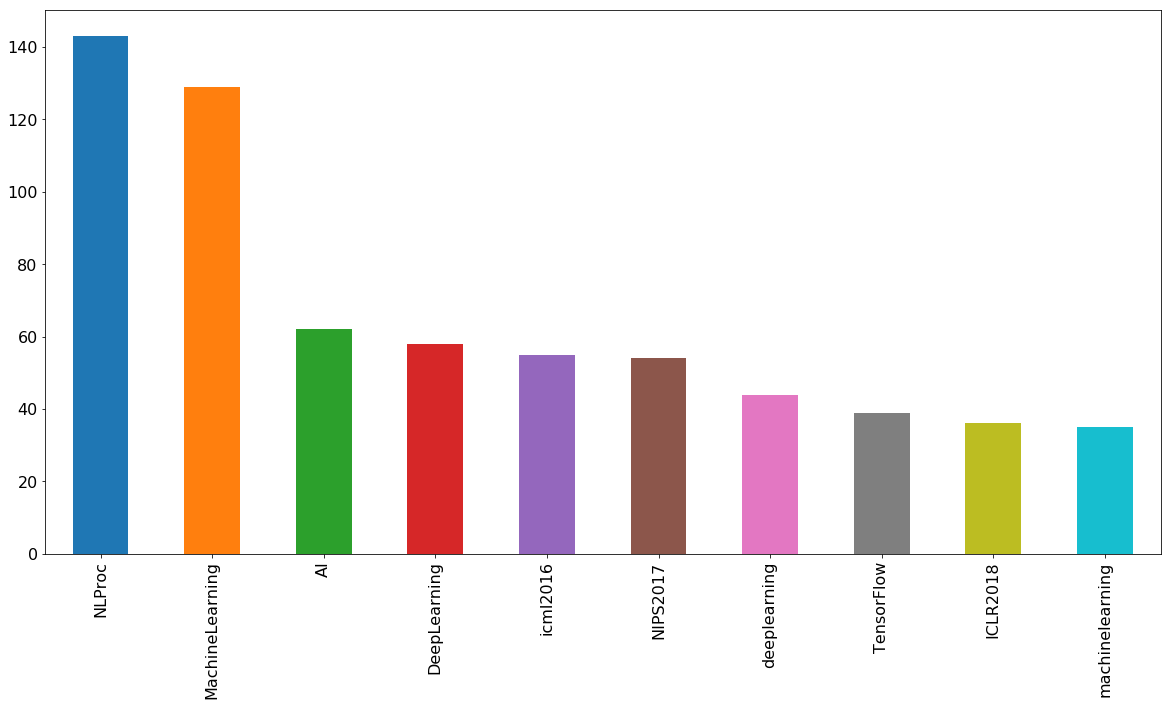

In [9]:
tweetsDF['hashtags'].value_counts()[1:11].plot(kind='bar', figsize=(20, 10), fontsize=16)

#### Top 10 authors

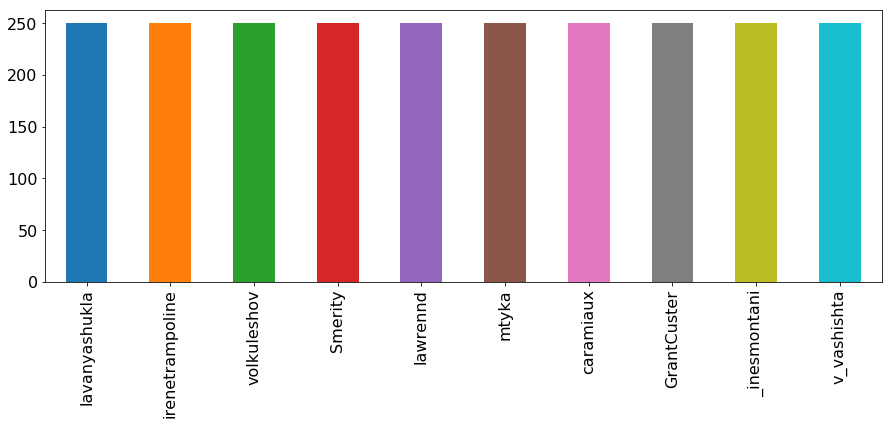

In [10]:
tweetsDF['screen_name'].value_counts()[1:11].plot(kind='bar', figsize=(15, 5), fontsize=16)

#### Top 20 locations

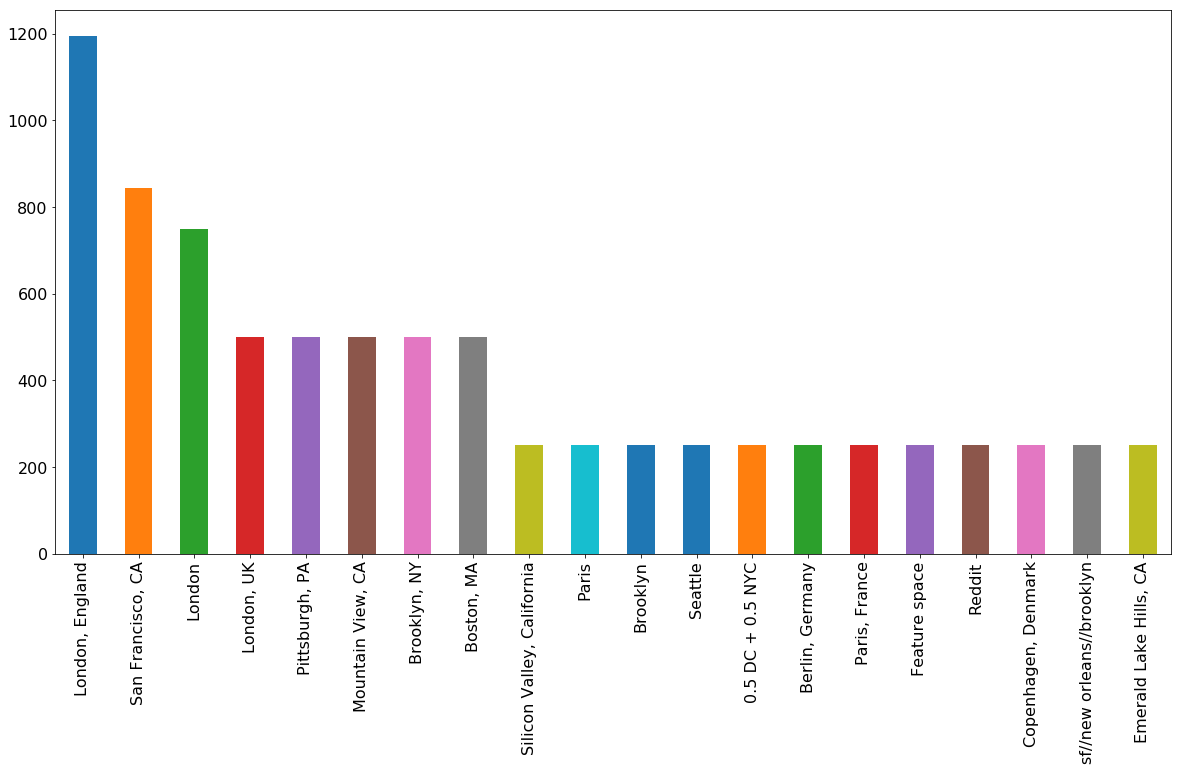

In [11]:
tweetsDF['location'].value_counts()[1:21].plot(kind='bar', figsize=(20, 10), fontsize=16)

####  Retweet ratio 

In [12]:
ratio = len(tweetsDF[tweetsDF['retweet']==True]) / len(tweetsDF) * 100.00
print("there are %.2f%% retweets in the dataset" % ratio)

there are 41.48% retweets in the dataset


#### Min / Max creation timestamps 

In [13]:
print("Min timestamp: %s" % min(tweetsDF['created_at_ts']))
print("Max timestamp: %s" % max(tweetsDF['created_at_ts']))

Min timestamp: 2009-12-26 21:55:12
Max timestamp: 2018-05-30 05:02:09


#### Monthly distribution (last 2 years)

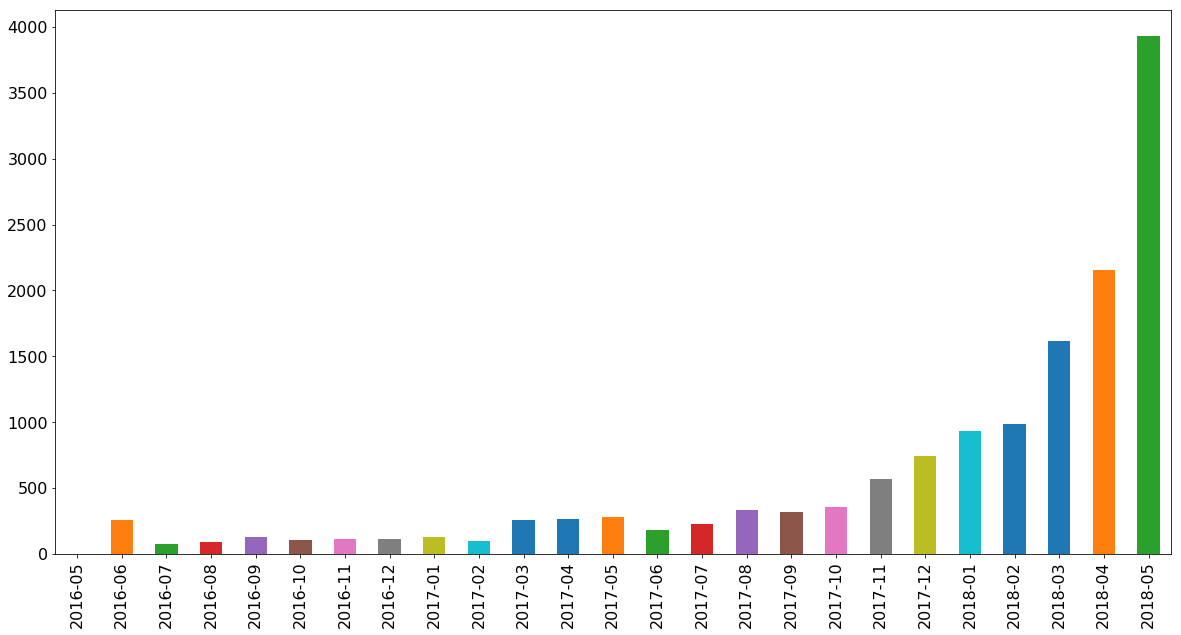

In [14]:
pd.options.mode.chained_assignment = None
subtweetsDF = tweetsDF[tweetsDF['created_at_ts'] >= '2016-05-30 00:00:00']
subtweetsDF.loc[:,'month'] = pd.to_datetime(subtweetsDF['created_at_ts']).dt.to_period('M')
subtweetsDF.groupby('month')['full_text'].count().reindex(pd.PeriodIndex
                                                          (start=subtweetsDF['month'].sort_values()
                                                           .iloc[0], periods=25)).plot(kind='bar', fontsize=16, 
                                                                                       figsize=(20, 10))

#### Monthly distribution (first 3 years)

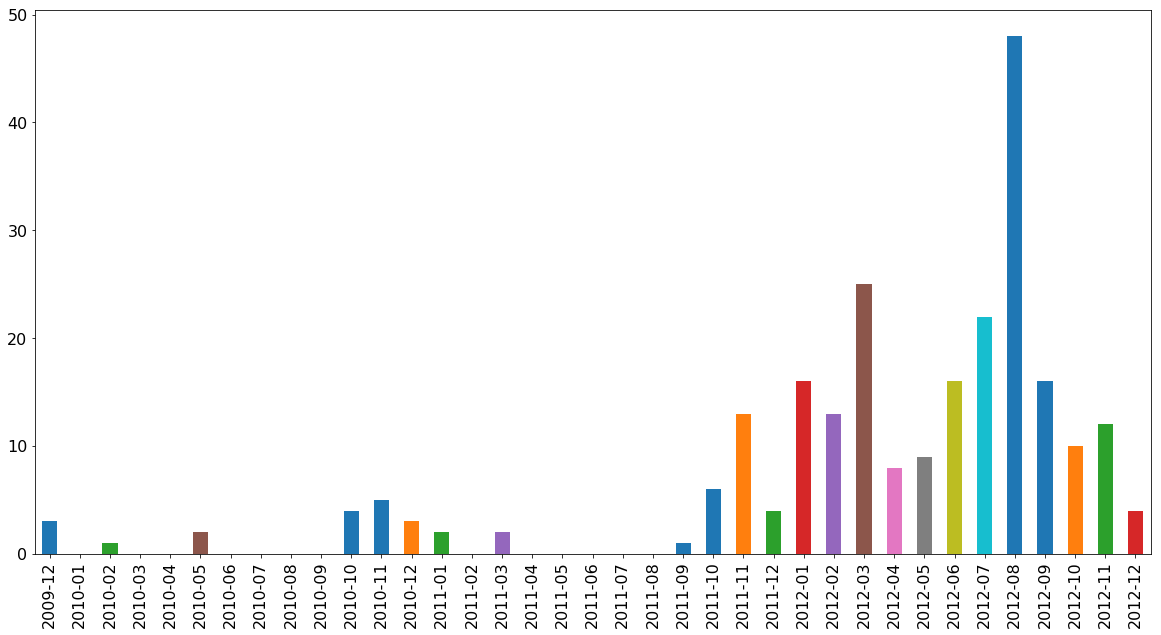

In [15]:
subtweetsDF = tweetsDF[tweetsDF['created_at_ts'] < '2013-01-01 00:00:00']
subtweetsDF.loc[:,'month'] = pd.to_datetime(subtweetsDF['created_at_ts']).dt.to_period('M')
subtweetsDF.groupby('month')['full_text'].count().reindex(pd.PeriodIndex
                                                          (start=subtweetsDF['month'].sort_values()
                                                           .iloc[0], periods=37)).plot(kind='bar', fontsize=16, 
                                                                                       figsize=(20, 10))

### Summary of Data Understanding
- Top hashtags distribution reveals that machine learning, deep learning, and AI are the main topics of tweets in this dataset. 
- The tweets are distributed equally by their authors (e.g. we have an equal number of tweets from each author).
- Authors are mainly located in the US, UK, and EU.
- There is a relatively high percentage of retweets (41%) in the dataset implying a possible high level of content duplication.
- The vast majority of the tweets are very recent (May 2018) with the volume gradually decreasing as we  move to less recent months. This might be due to the use a rate limited API to fetch the tweets. However, it might be that there are emerging subtopics (e.g. events) in the content whose popularity tend to increase with time.
- A small proportion of the tweets are relatively old (tweeted between 2010 and 2013) with an obvious cluster of tweets authored within 2012 that may be interesting for further content analysis. 

### Data Preparation

This phase is about cleansing up and preparing the text attribute of the tweets for the machine learning modelling phase. This involves:

- Aggregate tweets into a dictionary of **documents**, where each document contains all the tweets that are authored during a month in the dataset.
- Remove documents having less than 10 tweets (1st-level filtration).
- Merge the list of tweets that belong to the same month (document) into a single text attribute.
- Remove URLs from the contents of the remaining documents.
- Remove documents with less than 1000 words (2nd-level filtration).
- Tokenize: break the documents into tokens. This also removes punctuation.
- For each document, remove stopwords, tokens that only occur once, and digits & words composed of only 1 or 2 characters.
- For all the documents, as well as for each month documents, build a dictionary where for each document, each token has its own id. 
- For all the documents, as well as for each month documents, build a corpus (e.g. vectors with the number of occurences of each token in each document)

In [16]:
#load libraries required for data preprocessing 
import nltk
import re
from collections import defaultdict
from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from string import digits

C:\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [17]:
#derive the 'month' attribute and use the month and full text attributes as features
tweetsDF.loc[:,'month'] = pd.to_datetime(tweetsDF['created_at_ts']).dt.to_period('M')
subtweetsDF = tweetsDF[['full_text', 'month']]

In [18]:
#aggregate tweets by the creation month 
subtweetsDF.month=subtweetsDF.month.astype(str)
subtweetsDict = subtweetsDF.groupby('month')['full_text'].apply(list).to_dict()
print("No of documents before data preprocessing: %d" % len(subtweetsDict.keys()))
#1st-level filtration & merge lists of tweets into string attributes
filtered1stsubtweetsDict = {}
for k in subtweetsDict.keys():
    if len(subtweetsDict[k]) >= 10:
        filtered1stsubtweetsDict[k] = " ".join(subtweetsDict[k])
print("No of documents after 1st-level filtration: %d" % len(filtered1stsubtweetsDict.keys()))
#remove URLs
for k in filtered1stsubtweetsDict.keys():
    filtered1stsubtweetsDict[k] = re.sub(r"(?:\@|http?\://)\S+", "", filtered1stsubtweetsDict[k])
#2nd-level filtration
filtered2ndsubtweetsDict = {}
for k in filtered1stsubtweetsDict.keys():
    if len(filtered1stsubtweetsDict[k]) >= 1000:
        filtered2ndsubtweetsDict[k] = filtered1stsubtweetsDict[k]
print("No of documents after 2nd-level filtration: %d" % len(filtered2ndsubtweetsDict.keys()))
#tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k] = tokenizer.tokenize(filtered2ndsubtweetsDict[k].lower())
#remove stopwords and statistically insignificant tokens
stoplist_tw=['amp','get','got','hey','hmm','hoo','hop','iep','let','ooo','par',
            'pdt','pln','pst','wha','yep','yer','aest','didn','nzdt','via',
            'one','com','new','like','great','make','top','awesome','best',
            'good','wow','yes','say','yay','would','thanks','thank','going',
            'new','use','should','could','best','really','see','want','nice',
            'while','know','https']
unigrams = list(set([ w for doc in filtered2ndsubtweetsDict.values() for w in doc if len(w)==1]))
bigrams  = list(set([ w for doc in filtered2ndsubtweetsDict.values() for w in doc if len(w)==2]))
stoplist  = set(nltk.corpus.stopwords.words("english") + stoplist_tw + unigrams + bigrams)
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k] = [token for token in filtered2ndsubtweetsDict[k] if token not in stoplist]
#remove words that only occur once
token_frequency = defaultdict(int)
for doc in filtered2ndsubtweetsDict.values():
    for token in doc:
        token_frequency[token] += 1
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k] = [token for token in filtered2ndsubtweetsDict[k] if token_frequency[token] > 1]
# Sort tokens in documents
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k].sort()
#build a dictionary for all documents as well as for each month
dictionaries = {}
dictionaries['all'] = corpora.Dictionary(filtered2ndsubtweetsDict.values())
dictionaries['all'].compactify()
for k in filtered2ndsubtweetsDict.keys():
    dictionaries[k] = corpora.Dictionary([filtered2ndsubtweetsDict[k]])
    dictionaries[k].compactify()
print("There are %d unique tokens in the dictionary of all documents." % len(dictionaries['all'].values()))
#build a corpus for all documents as well as for each month
corpora = {}
corpora['all'] = [dictionaries['all'].doc2bow(doc) for doc in filtered2ndsubtweetsDict.values()]
for k in filtered2ndsubtweetsDict.keys():
    corpora[k] = [dictionaries[k].doc2bow(filtered2ndsubtweetsDict[k])]

No of documents before data preprocessing: 88
No of documents after 1st-level filtration: 52
No of documents after 2nd-level filtration: 44
There are 10162 unique tokens in the dictionary of all documents.


### Modelling
- As the given dataset does not come with a ground truth set of human verified / tagged labels that represent the different topics / subtopics of the content, we will adopt an **unsupervised learning** approach to **Topic Modelling**, to uncover the underlying subtopics for both the whole preprocessed corpus as well as the mobthly corpora, trying to identify emerging topics that could be of interest for the machine learning crowd. 
- For that, we will use the well-known [Latent Dirichlet Allocation (LDA)](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) approach to build several topic models and compare between uncovered topics to visually evaluate the approach.
- In LDA, there are 3 main [hyperparameters](https://stats.stackexchange.com/questions/37405/natural-interpretation-for-lda-hyperparameters) which need to be optimized:
  - K: the number of topics.
  - Alpha: the number of potential topics per document. The lower alpha, the lower the number of topics per documents.
  - Passes: the number of training passes through the corpus.
- As this task is purely demosntrational and finding the optimal values for the LDA hyperparameters for LDA is **an art**, we will select the values intuitively:
    - K: 10
    - Alpha: 0.01
    - Passes: 10 

In [19]:
#select hyperparameters
lda_params = {'num_topics': 10, 'passes': 10, 'alpha': 0.01}
print("Training LDA models with: %s  " % lda_params)

Training LDA models with: {'alpha': 0.01, 'num_topics': 10, 'passes': 10}  


In [20]:
#train LDA models for all documents as well as for each month
LDAs = {}
for k in corpora.keys():
    LDAs[k] = models.LdaModel(corpora[k], 
                    id2word=dictionaries[k],
                    num_topics=lda_params['num_topics'],
                    passes=lda_params['passes'],
                    alpha = lda_params['alpha'])

### Evaluation

- We will visually evaluate the approach by interactively inspecting the significant topics uncovered by the all-documents-LDA model, and then comparing them with the significant topics uncovered by an arbitrary selection of month-specific models representing different time windows. 
- We will use the [pyLDAvis](https://github.com/bmabey/pyLDAvis) library for the interactive visualisation of the LDA topic models. 
- By default the topics are projected to a 2D plane, depicting the distances between the various topics for the model. we can interactively select each topic to identify its top N most relevant tokens. 
- We can further customize the visualized tokens for every topic using the relevance metric **Lambda**, having the scale [0.0 - 1.0]. Lower lambda values increase the ratio of the estimated term frequency within the selected topic to the overall term frequency. In other words, Lowering Lambda gives more importance to tokens that are discriminatory for the selected topic, which consequently best define the topic. Having this in mind, the recommendation is to keep Lamda relatively low (e.g. 0.0 - 0.1).

In [21]:
import pyLDAvis.gensim

In [22]:
#the keys of all the LDA models we have trained in the modelling phase
LDAs.keys()

dict_keys(['2012-03', '2018-03', '2018-05', '2017-12', '2016-11', '2015-05', '2017-02', '2016-04', '2015-04', '2018-04', '2014-06', '2017-08', '2015-06', '2017-01', '2015-07', '2017-05', '2016-09', '2016-08', '2015-11', '2016-01', '2016-06', '2017-04', '2018-02', '2016-05', '2012-06', '2017-06', '2012-07', '2016-12', '2012-09', '2017-11', '2013-02', '2015-12', '2012-01', '2016-02', '2016-10', '2018-01', '2016-03', '2017-03', '2017-09', '2015-10', 'all', '2012-08', '2017-10', '2016-07', '2017-07'])

In [23]:
# LDA model for all documents
all_docs_topics =  pyLDAvis.gensim.prepare(LDAs['all'], corpora['all'], dictionaries['all'])
pyLDAvis.display(all_docs_topics)

C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [24]:
# LDA model for tweets authored in 2018-05
month = '2018-05'
month_topics =  pyLDAvis.gensim.prepare(LDAs[month], corpora[month], dictionaries[month])
pyLDAvis.display(month_topics)

C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [25]:
# LDA model for tweets authored in 2017-12
month = '2017-12'
month_topics =  pyLDAvis.gensim.prepare(LDAs[month], corpora[month], dictionaries[month])
pyLDAvis.display(month_topics)

C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [26]:
# LDA model for tweets authored in 2016-06
month = '2016-06'
month_topics =  pyLDAvis.gensim.prepare(LDAs[month], corpora[month], dictionaries[month])
pyLDAvis.display(month_topics)

C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [27]:
# LDA model for tweets authored in 2015-04
month = '2015-04'
month_topics =  pyLDAvis.gensim.prepare(LDAs[month], corpora[month], dictionaries[month])
pyLDAvis.display(month_topics)

C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [28]:
# LDA model for tweets authored in 2012-08
month = '2012-08'
month_topics =  pyLDAvis.gensim.prepare(LDAs[month], corpora[month], dictionaries[month])
pyLDAvis.display(month_topics)

C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\Anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


### Summary of Evaluation

- When compared with some month-specific model topics, it is obviously noticed that the various topics which are highlighted as significant by the all-documents model are correlated with their related time windows. This is especially obvious for Machine Learning events / conferences and very emerging topics. Here are some examples (**Note**: The topic ids can change when rerunning the Jupyter Notebook cells as LDA does not maintain the same ids with the same uncovered topics for every execution):

  - Topic (2) in all-docments LDA model significantly highlights GDPR, this is aligned with the '2018-05' LDA model, suggesting that GDPR (General Data Protection Regulation) is a very emerging topic within the machine learning crowd. 
  - Topic (1) in all-docments LDA model significantly highlights the NIPS2017 conference, this is aligned with the '2017-12' LDA model, when the NIPS 2017 conference occured. 
  - Topic (3) in all-docments LDA model significantly highlights the ICML2016 conference, this is aligned with the '2016-06' LDA model, when the ICML 2016 conference occured.
  - Topic (5) in all-docments LDA model significantly highlights the CHI2015 conference, this is aligned with the '2015-04' LDA model, when the CHI 2015 conference occured.
- The above examples provide a promising positive impression on the evaluation approach used. In other words, the significance of machine learning-related topics uncovered by an **all-documents LDA model** can be validated by how this significance is alighed with what **time window-specific LDA models** reveal).